# Results for ROBERTA when applying syn tranformation to both premise and hypothesis

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder 
from lr.analysis.util import get_rho_stats_from_result_list
from lr.stats.h_testing import get_ks_stats_from_p_values_compared_to_uniform_dist

## Get Results

In [2]:
all_accs = []
all_transformed_accs = []
all_paired_t_p_values = []
test_repetitions = 2


batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    test_accuracy  = get_ts_from_results_folder(path="results/snli/roberta_base/syn_p_h/batch{}/".format(i),
                                                 stat="test_accuracy")
    
    transformed_test_accuracy = get_ts_from_results_folder(path="results/snli/roberta_base/syn_p_h/batch{}/".format(i),
                                                           stat="transformed_test_accuracy")
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/snli/roberta_base/syn_p_h/batch{}/".format(i),
                                                    stat="paired_t_p_value")
    
    all_accs.append(test_accuracy)
    all_transformed_accs.append(transformed_test_accuracy)
    all_paired_t_p_values.append(paired_t_p_value)

100%|██████████| 2/2 [00:00<00:00, 15.09it/s]


## Accuracy

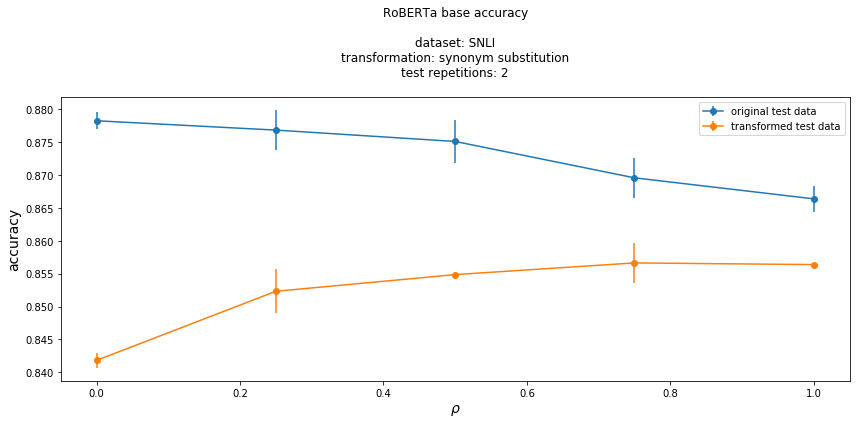

In [4]:
rhos, y, error = get_rho_stats_from_result_list(all_accs)

_, y_t, error_t = get_rho_stats_from_result_list(all_transformed_accs)

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(rhos, y, yerr=error, fmt='-o', label="original test data");
ax.errorbar(rhos, y_t, yerr=error_t, fmt='-o', label="transformed test data");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("accuracy", fontsize=14);
ax.set_title("RoBERTa base accuracy\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.savefig('figs/roberta_base_acc_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values

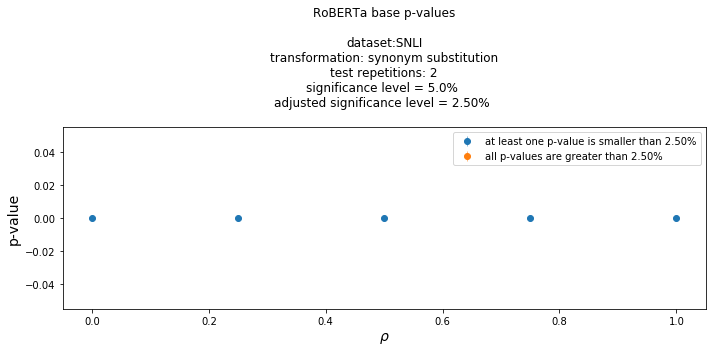

In [6]:
rhos, y, error = get_rho_stats_from_result_list(all_paired_t_p_values)

alpha = 0.05
alpha_adj = alpha / test_repetitions

rejected_ids = []
remain_ids = []

for i,v in enumerate(y):
    if v < alpha_adj:
        rejected_ids.append(i)
    else:
        remain_ids.append(i)
        
rhos_rejected = rhos[rejected_ids]
rhos_remain = rhos[remain_ids]
y_rejected = y[rejected_ids]
y_remain = y[remain_ids]
error_rejected = error[rejected_ids]
error_remain = error[remain_ids]

title_msg = "RoBERTa base p-values\n\ndataset:"
title_msg += "SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions)
title_msg += "significance level = {:.1%} \n".format(alpha)
title_msg += "adjusted significance level = {:.2%} \n".format(alpha_adj)


fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(rhos_rejected, y_rejected, yerr=error_rejected, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax.errorbar(rhos_remain, y_remain, yerr=error_remain, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title(title_msg);
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/roberta_base_p_values_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

### Ploting the Kolmogorov–Smirnov statistic

In [7]:
ks_stats = []
for rho in tqdm(rhos):
    p_ts = pd.DataFrame(all_paired_t_p_values).transpose().loc[rho,:]
    ks = get_ks_stats_from_p_values_compared_to_uniform_dist(p_ts)
    ks_stats.append(ks)
    
ks_stats = pd.Series(ks_stats, index=rhos)

100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


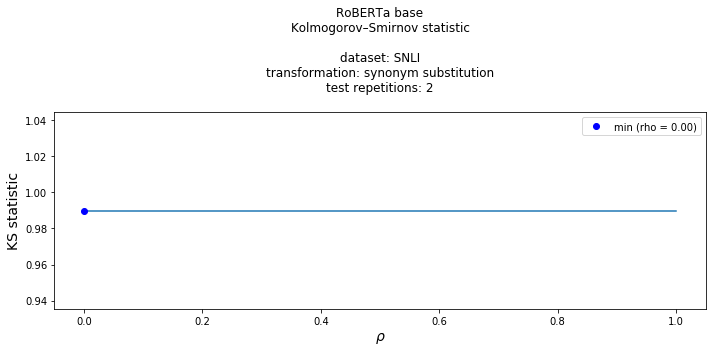

In [10]:
id_min = ks_stats.argmin() 
rho_min, v_min = ks_stats.index[id_min], ks_stats.iloc[id_min], 


fig, ax = plt.subplots(figsize=(10,5))
ks_stats.plot(label='_nolegend_');
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("KS statistic", fontsize=14);
ax.set_title("RoBERTa base\nKolmogorov–Smirnov statistic\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
ax.plot(rho_min, v_min, "o", color="blue", label="min (rho = {:.2f})".format(rho_min))
fig.tight_layout()
ax.legend(loc="best");
fig.savefig('figs/roberta_base_ks_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

### Using the Kolmogorov–Smirnov statistic to select one $\rho$

In [9]:
average_acc = pd.DataFrame(all_accs).transpose().loc[rho_min,:].mean()
average_transformed_acc = pd.DataFrame(all_transformed_accs).transpose().loc[rho_min,:].mean()

analysis = {"dataset":"snli",
            "model": "RoBERTa base",
            "rho":rho_min,
            "average_test_accuracy": average_acc,
            "average_transformed_test_accuracy": average_transformed_acc,
            "combined_accuracy": np.mean([average_acc, average_transformed_acc])}
analysis = pd.DataFrame(analysis, index=[0])
analysis

,dataset,model,rho,average_test_accuracy,average_transformed_test_accuracy,combined_accuracy
0,snli,RoBERTa base,0.0,0.878277,0.8418,0.860039


### Plotting ECDF

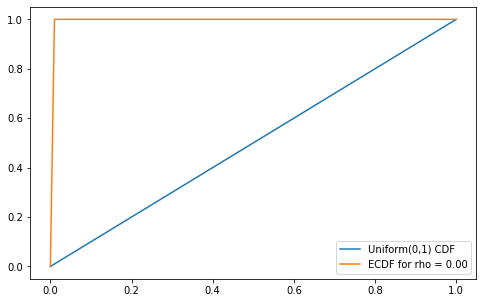

In [11]:
def get_ecdf(series_):
    f = lambda x: (series_.sort_values() < x).astype(int).mean()
    return np.vectorize(f)

def cdf_u_0_1(x):
    assert 0 <= x <=1
    return x

cdf_u_0_1 = np.vectorize(cdf_u_0_1)

size = 100
x = np.linspace(0, 1, size)
p_ts = pd.DataFrame(all_paired_t_p_values).transpose().loc[1.00,:]
ecdf = get_ecdf(p_ts)
diff = np.abs(cdf_u_0_1(x) - ecdf(x))
id_max = np.argmax(diff)
diff_max = diff[id_max]
u10 = pd.Series(cdf_u_0_1(x), index=x)
u10.name = "Uniform(0,1) CDF"
empirical = pd.Series(ecdf(x), index=x)
empirical.name = "ECDF for rho = {:.2f}".format(rho_min)

fig, ax = plt.subplots(figsize=(8,5))
u10.plot();
empirical.plot();
ax.legend(loc="best");